In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix

# Lokasi folder utama dataset
base_dir = 'dataset'

# Cek apakah folder terbaca
if os.path.exists(base_dir):
    print("Folder dataset ditemukan!")
    print(f"Isi folder: {os.listdir(base_dir)}")
    
    # Cek jumlah file per kelas [cite: 22, 23]
    iklan_count = len(os.listdir(os.path.join(base_dir, 'iklan')))
    non_iklan_count = len(os.listdir(os.path.join(base_dir, 'noniklan')))
    print(f"Jumlah Iklan: {iklan_count}")
    print(f"Jumlah Non-Iklan: {non_iklan_count}")
else:
    print("ERROR: Folder 'dataset' belum diupload ke Colab.")

Folder dataset ditemukan!
Isi folder: ['iklan', 'noniklan']
Jumlah Iklan: 150
Jumlah Non-Iklan: 150


In [2]:
# Konfigurasi
IMG_SIZE = (224, 224)
BATCH_SIZE = 5  # Batch kecil karena total data hanya 50 gambar

# 1. Generator untuk Training (dengan Augmentasi agar model lebih pintar) [cite: 32]
train_datagen = ImageDataGenerator(
    rescale=1./255,       # Normalisasi 0-1
    rotation_range=20,    # Putar gambar sedikit
    horizontal_flip=True, # Balik gambar horizontal
    fill_mode='nearest',
    validation_split=0.3  # Split 30% untuk validasi
)

# 2. Generator untuk Validasi (Tanpa augmentasi)
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.3
)

# Muat Data Training
print("Data Training:")
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',  # <-- GANTI INI (Tadinya 'binary')
    subset='training'
)

# Muat Data Validasi
print("\nData Validasi:")
validation_generator = val_datagen.flow_from_directory(
    base_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',  # <-- GANTI INI JUGA (Tadinya 'binary')
    subset='validation',
    shuffle=False 
)

Data Training:
Found 210 images belonging to 2 classes.

Data Validasi:
Found 90 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau # <-- Import modul baru

# 1. Setup Base Model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# 2. Tambahkan Layer Custom
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)

# --- PERUBAHAN 1: GANTI ACTIVATION ---
# Karena pakai konsep 'Cross Entropy' (Categorical), outputnya jadi 2 neuron (Iklan & Non-Iklan)
# Activation diganti jadi 'softmax'
output = Dense(2, activation='softmax')(x) 

model = Model(inputs=base_model.input, outputs=output)

# 3. Setup Callbacks (Fitur Tambahan)

# --- PERUBAHAN 2: EARLY STOPPING ---
# Berhenti training otomatis kalau val_loss tidak membaik setelah 10 epoch
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    restore_best_weights=True,
    verbose=1
)

# --- PERUBAHAN 3: LEARNING RATE DINAMIS ---
# Turunkan Learning Rate kalau performa mentok (stagnan)
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5,     # Kurangi LR jadi setengahnya
    patience=5,     # Tunggu 5 epoch kalau gak ada kemajuan baru kurangi
    min_lr=1e-6,    # Batas minimum LR
    verbose=1
)

# 4. Compile Model
model.compile(
    optimizer=Adam(learning_rate=0.0001), # LR awal
    loss='categorical_crossentropy',      # <-- Loss untuk Softmax (2 kelas atau lebih)
    metrics=['accuracy']
)

model.summary()

In [4]:
# Tentukan jumlah Epoch (mau diputar berapa kali)
EPOCHS = 30 

# --- INI BAGIAN YANG BIKIN JADI DINAMIS ---
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    # KUNCINYA DI SINI!
    # Kita masukkan 'early_stop' (biar stop otomatis kalau gak ada kemajuan)
    # Kita masukkan 'lr_scheduler' (biar Learning Rate berubah otomatis/dinamis)
    callbacks=[early_stop, lr_scheduler] 
)

Epoch 1/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 151ms/step - accuracy: 0.3571 - loss: 1.0982 - val_accuracy: 0.5444 - val_loss: 0.7188 - learning_rate: 1.0000e-04
Epoch 2/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 0.6238 - loss: 0.6688 - val_accuracy: 0.7000 - val_loss: 0.5589 - learning_rate: 1.0000e-04
Epoch 3/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.7810 - loss: 0.5028 - val_accuracy: 0.7778 - val_loss: 0.4612 - learning_rate: 1.0000e-04
Epoch 4/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 0.8476 - loss: 0.3773 - val_accuracy: 0.8444 - val_loss: 0.3893 - learning_rate: 1.0000e-04
Epoch 5/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 0.9095 - loss: 0.3020 - val_accuracy: 0.8667 - val_loss: 0.3365 - learning_rate: 1.0000e-04
Epoch 6/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 0.9333 - loss: 0.2251 - val_accuracy: 0.9000 - val_loss: 0.3009 - learning_rate: 1.0000e-04
Epoch 7/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy:

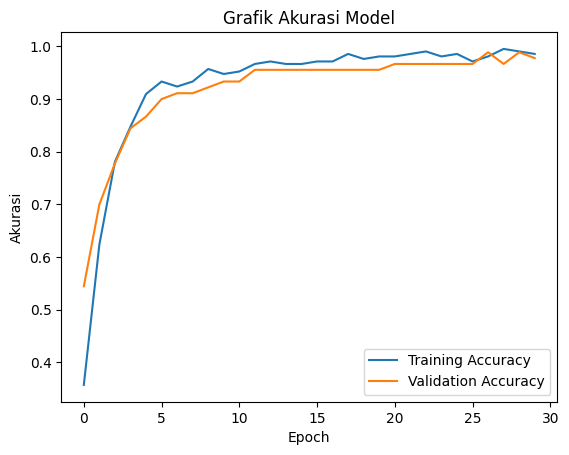


--- Laporan Evaluasi ---
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step

Confusion Matrix (Baris=Asli, Kolom=Prediksi):
[[44  1]
 [ 1 44]]

Detail Akurasi:
              precision    recall  f1-score   support

       iklan       0.98      0.98      0.98        45
    noniklan       0.98      0.98      0.98        45

    accuracy                           0.98        90
   macro avg       0.98      0.98      0.98        90
weighted avg       0.98      0.98      0.98        90



In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# --- 1. Plot Grafik Akurasi (Ini Aman, Tetap Dipakai) ---
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Grafik Akurasi Model')
plt.ylabel('Akurasi')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# --- 2. Confusion Matrix & Laporan (INI YANG DIPERBAIKI) ---
print("\n--- Laporan Evaluasi ---")

# Reset generator biar urutan datanya mulai dari awal lagi (PENTING!)
validation_generator.reset()

# Prediksi (Hasilnya berupa probabilitas 2 kolom)
Y_pred = model.predict(validation_generator)

# AMBIL NILAI TERTINGGI (Perbaikan untuk Softmax/Categorical)
# Kalau kolom 0 lebih besar -> Iklan, Kalau kolom 1 -> Non-Iklan
y_pred = np.argmax(Y_pred, axis=1)

# Ambil label asli dari folder
y_true = validation_generator.classes

# Ambil nama kelas (Iklan/NonIklan)
target_names = list(train_generator.class_indices.keys())

# Tampilkan Matrix
print('\nConfusion Matrix (Baris=Asli, Kolom=Prediksi):')
print(confusion_matrix(y_true, y_pred))

# Tampilkan Laporan Lengkap
print('\nDetail Akurasi:')
print(classification_report(y_true, y_pred, target_names=target_names))  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 873ms/step


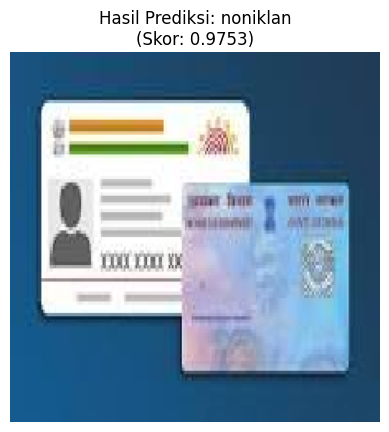

In [6]:
from tensorflow.keras.utils import load_img, img_to_array

# Ganti nama file sesuai gambar yang Anda upload untuk tes
path_gambar_tes = 'tes_iklan.jpg' 

if os.path.exists(path_gambar_tes):
    # Proses gambar agar sesuai input model
    img = load_img(path_gambar_tes, target_size=(224, 224))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0 # Normalisasi

    # Prediksi
    hasil_angka = model.predict(x)[0][0]
    
    # Tentukan label
    # Cek mapping: {'iklan': 0, 'noniklan': 1}
    label_map = {v: k for k, v in train_generator.class_indices.items()}
    prediksi_teks = label_map[int(hasil_angka > 0.5)]
    
    # Tampilkan
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Hasil Prediksi: {prediksi_teks}\n(Skor: {hasil_angka:.4f})")
    plt.show()
else:
    print(f"File {path_gambar_tes} tidak ditemukan. Upload dulu gambarnya.")